<a href="https://colab.research.google.com/github/yeseul106/Deep-Learning/blob/master/whale_tail_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, GlobalMaxPooling2D, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

np.random.seed(3)
tf.random.set_seed(3)

Mounted at /content/gdrive


In [ ]:
'''category가 몇개 있는지 확인 (고래의 종류)'''
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')
# train_df.head()
category_num=len(df['Id'].unique())  #4251 (고래의 종류가 4251가지)
df['Id'].value_counts()

'''각 카테고리가 몇개씩 있는지 확인'''
group_df = df.groupby('Id').count()
group_df = group_df.reset_index()
print(group_df.sort_values(by='Image'))
# print(group_df)

'''10개 이하의 이미지를 가진 카테고리 제거'''
valid_category = []
valid_category = group_df[group_df.Image>10]
print(len(valid_category))
# print(valid_category.sort_values(by='Image'))

'''train 데이터와 test 데이터 나누기'''
df = df[df['Id'].isin(valid_category['Id'])]  #1699 rows X 2 columns
print(df)
# train_size = (int)(len(df)*0.7)
# train_df = df[:train_size]
# test_df = df[train_size:]  <== 문제점은 trian_set과 test_set에 카테고리 비율이 다름
train_df, test_df = train_test_split(df,test_size=0.3, stratify=df['Id'])

             Id  Image
4250  w_ffdab7a      1
1640  w_6384242      1
1641  w_6398e9d      1
1642  w_639aed5      1
2956  w_b170173      1
...         ...    ...
498   w_1eafe46     23
1951  w_7554f44     26
2580  w_98baff9     27
310   w_1287fbc     34
0     new_whale    810

[4251 rows x 2 columns]
57
             Image         Id
1     000466c4.jpg  w_1287fbc
2     00087b01.jpg  w_da2efe0
7     0031c258.jpg  new_whale
13    00467ae9.jpg  w_fd1cb9d
19    007c3603.jpg  new_whale
...            ...        ...
9826  ff4bb3a4.jpg  w_2d99a0c
9828  ff6946b4.jpg  w_17ee910
9834  ff9d60a3.jpg  w_eb0a6ed
9837  ffb71ac2.jpg  new_whale
9844  ffd1e7aa.jpg  new_whale

[1699 rows x 2 columns]


In [ ]:
'''이미지 부풀리기'''
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2,
                                   rotation_range=15, shear_range=0.7, fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe= train_df, #데이터 프레임
    directory= '/content/gdrive/My Drive/Colab Notebooks/train', #데이터 위치
    x_col = 'Image', #파일 위치 열이름
    y_col = 'Id',  #분류할 클래스 열이름
    target_size=(200, 200),
    batch_size=30,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df, #데이터 프레임
    directory= '/content/gdrive/My Drive/Colab Notebooks/train',  #데이터 위치
    x_col= 'Image', #파일 위치 열이름
    y_col = 'Id', #분류할 클래스 열이름
    target_size=(200, 200),
    batch_size=30,
    class_mode='categorical')

'''전이 학습을 위해 VGG16을 나의 네트워크 전에 삽입한다!'''
from keras.applications.vgg16 import VGG16

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))
transfer_model.trainable= False  #학습 시킬 것이 아니므로 False
final_model= Sequential()
final_model.add(transfer_model)
final_model.add(Dropout(0.3))
final_model.add(Flatten())
final_model.add(Dense(256,activation='relu'))
final_model.add(Dropout(0.3))
final_model.add(Dense(57, activation='softmax'))

# '''set CNN model'''
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64,(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4251, activation='softmax'))  #출력층 노드 5개

final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = final_model.fit_generator(
    train_generator,
    steps_per_epoch=10, epochs=30, validation_data= test_generator, validation_steps=4)

Found 1189 validated image filenames belonging to 57 classes.
Found 510 validated image filenames belonging to 57 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 7s 627ms/step - loss: 5.0627 - accuracy: 0.2449 - val_loss: 3.2323 - val_accuracy: 0.4250
Epoch 2/30
10/10 [==============================] - 6s 591ms/step - loss: 3.2403 - accuracy: 0.4342 - val_loss: 3.0363 - val_accuracy: 0.4417
Epoch 3/30
10/10 [==============================] - 6s 598ms/step - loss: 2.8758 - accuracy: 0.4774 - val_loss: 2.9146 - val_accuracy: 0.4500
Epoch 4/30
10/10 [==============================] - 6s 588ms/step - loss: 2.7282 - accuracy: 0.5260 - val_loss: 2.7046 - val_accuracy: 0.4917
Epoch 5/30
10/10 [==============================] - 6s 594ms/step - loss: 2.9087 - accuracy: 0.4825 - val_loss: 2.7419 - val_accuracy: 0.4667
Epoch 6/30
10/10 [==============================] - 6s 587ms/step - loss: 2.9236 - accuracy: 0.4647 - val_loss: 2.7800 - val_accuracy: 0.4583
Epoch 7/30
10/10 [==============================] - 6s 576ms/step - loss: 2.9120 - accuracy: 0.4362 - val_loss: 2.8223 - val_accuracy: 0.4333
Epoch 

In [ ]:
'''미세조정'''
transfer_model.trainable = True

from keras.optimizers import Adam

final_model.compile(optimizer=Adam(1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

history = final_model.fit_generator(
    train_generator,
    steps_per_epoch=10, epochs=30, validation_data= test_generator, validation_steps=4)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 8s 696ms/step - loss: 2.3497 - accuracy: 0.4766 - val_loss: 2.0744 - val_accuracy: 0.5167
Epoch 2/30
10/10 [==============================] - 7s 682ms/step - loss: 2.3076 - accuracy: 0.5141 - val_loss: 2.2157 - val_accuracy: 0.5167
Epoch 3/30
10/10 [==============================] - 7s 685ms/step - loss: 2.3340 - accuracy: 0.4660 - val_loss: 2.6404 - val_accuracy: 0.4500
Epoch 4/30
10/10 [==============================] - 7s 683ms/step - loss: 2.0772 - accuracy: 0.5200 - val_loss: 2.1867 - val_accuracy: 0.5500
Epoch 5/30
10/10 [==============================] - 7s 677ms/step - loss: 2.2535 - accuracy: 0.5353 - val_loss: 2.1981 - val_accuracy: 0.5167
Epoch 6/30
10/10 [==============================] - 7s 688ms/step - loss: 2.2465 - accuracy: 0.5009 - val_loss: 2.3900 - val_accuracy: 0.4667
Epoch 7/30
10/10 [==============================] - 7s 687ms/step - loss: 2.3745 - accuracy: 0.4310 - val_loss: 2.1905 - val_accuracy: 0.5167
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy: 51.33%


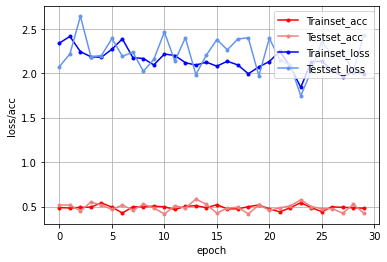

In [ ]:
 '''model 평가하기'''
scores = final_model.evaluate_generator(
            test_generator, 
            steps = 5)

print("Test %s: %.2f%%" %(final_model.metrics_names[1], scores[1]*100))

 '''graph로 표현'''
y_vloss = history.history['val_loss']  #테스트셋 오차
y_loss = history.history['loss']  #학습셋 오차
y_vacc = history.history['val_accuracy']  #테스트셋 정확률
y_acc = history.history['accuracy']  #학습셋 정확률

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, y_vacc, marker='.', c='lightcoral', label='Testset_acc')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')
plt.plot(x_len, y_vloss, marker='.', c='cornflowerblue', label='Testset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()
